## Test the Quantum Annealing Simultation

### Test the DL-DFT neural network with the two magnetizations $\mathbf{x}$ and $\mathbf{z}$

Imports

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.training.models_adiabatic import Energy_XXZX

Data

In [9]:
data=np.load('data/kohm_sham_approach/disorder/reduction_2_input_channel_dataset_h_0.0-2.0_omega_0.0-2.0_j_1_1nn_n_500000.npz')

ndata=1000

z=data['density']
f=data['density_F']
h=data['potential']
e=data['energy']

z_torch=torch.from_numpy(z[:ndata])
f_torch=torch.from_numpy(f[:ndata])
h_torch=torch.from_numpy(h[:ndata])
e_torch=torch.from_numpy(e[:ndata])


print(h_torch.shape)
print(z_torch.shape)

model=torch.load('model_rep/kohm_sham/disorder/model_zzxz_reduction_2_input_channel_dataset_h_0.0-2.0_omega_0.0-2.0_j_1_1nn_n_500k_unet_l_train_8_[40, 40, 40, 40, 40, 40]_hc_5_ks_1_ps_6_nconv_0_nblock',map_location='cpu')
model.eval()



torch.Size([1000, 2, 8])
torch.Size([1000, 2, 8])


TDDFTadiabaticModel(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(2, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 2): GELU()
    )
    (2): Sequential(
      (conv3): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 3): GELU()
    )
    (3): Sequential(
      (conv4): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 4): GELU()
    )
    (4): Sequential(
      (conv5): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 5): GELU()
    )
    (5): Sequential(
      (conv6): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation_6): GELU()
    )
  )
  (conv_upsample): 

See the samples

The potential

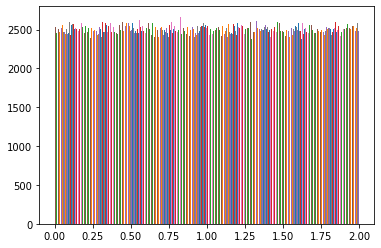

In [10]:
plt.hist(h[:,0],bins=200)
plt.show()

Magnetization $\mathbf{z}$

In [ ]:
for i in range(0,10):
    plt.plot(z[i,1,:])
    plt.plot(h[i,1,:])
    plt.show()

Test

Respect to z

In [11]:
z=z_torch[:,0,:]
z.requires_grad_(True)
print(z.shape)
input=torch.cat((z.unsqueeze(1),z_torch[:,1,:].unsqueeze(1)),dim=1)
f_ml=model(input)
f_ml.backward(torch.ones_like(f_ml))
print(z_torch[:,0,:].is_leaf)
df=torch.mean((f_ml-f_torch),dim=-1)
df_abs=torch.mean(torch.abs((f_ml-f_torch)),dim=-1)
print(df_abs.shape)
print(df_abs.mean())

torch.Size([1000, 8])
True
torch.Size([1000])
tensor(0.0003, dtype=torch.float64, grad_fn=<MeanBackward0>)


Visualization of $\mathbf{f}$

In [ ]:
for i in range(10):
    plt.plot(f_ml.detach().numpy()[i,:])
    plt.plot(f_torch.detach().numpy()[i,:])
    plt.show()

Gradient of $f_{ml}$

In [13]:
with torch.no_grad():
    grad = z.grad.clone()
    z.grad.zero_()

grad=grad

print(grad.shape)
print(h_torch.shape)


torch.Size([1000, 8])
torch.Size([1000, 2, 8])


The reconstruction of the field respect to $\mathbf{z}$

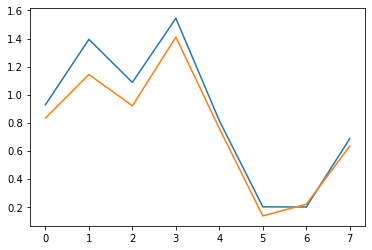

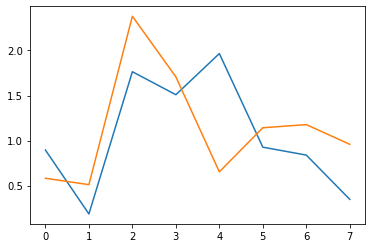

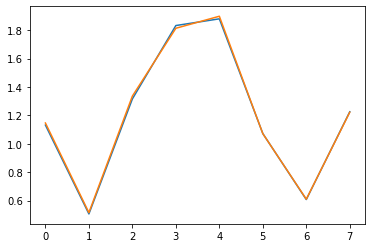

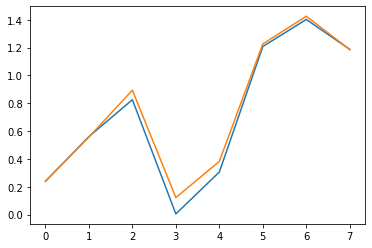

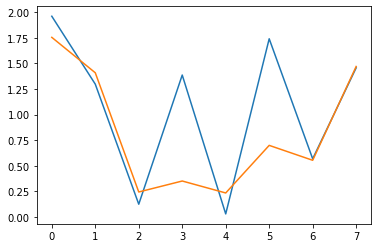

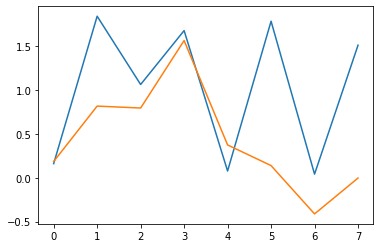

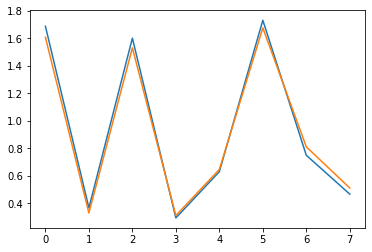

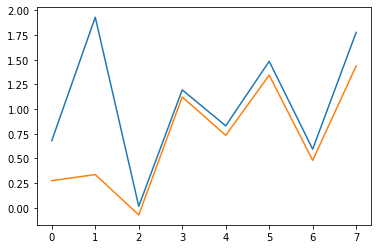

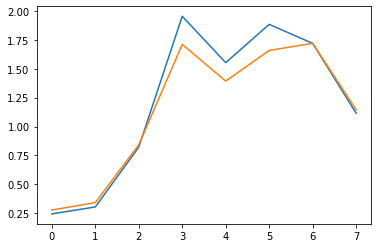

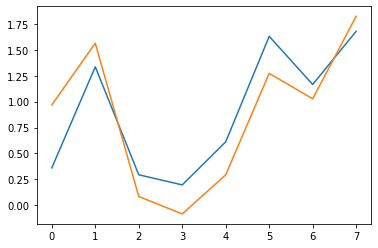

In [14]:
for i in range(10):
    plt.plot(h_torch[i,0,:].detach().numpy())
    plt.plot(-1*grad[i,:].detach().numpy())
    plt.show()

Respect to x

In [15]:
x=z_torch[:,1,:]
x.requires_grad_(True)
print(x.shape)
input=torch.cat((z_torch[:,0,:].unsqueeze(1),x.unsqueeze(1)),dim=1)
f_ml=model(input)
f_ml.backward(torch.ones_like(f_ml))
print(z_torch[:,0,:].is_leaf)
df=torch.mean((f_ml-f_torch),dim=-1)
df_abs=torch.mean(torch.abs((f_ml-f_torch)),dim=-1)
print(df_abs.shape)
print(df_abs.mean())

with torch.no_grad():
    grad = x.grad.clone()
    x.grad.zero_()

grad=grad

print(grad.shape)
print(h_torch.shape)

torch.Size([1000, 8])
True
torch.Size([1000])
tensor(0.0003, dtype=torch.float64, grad_fn=<MeanBackward0>)
torch.Size([1000, 8])
torch.Size([1000, 2, 8])


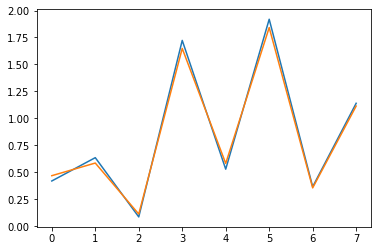

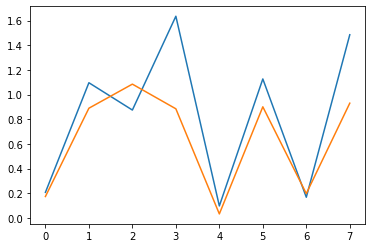

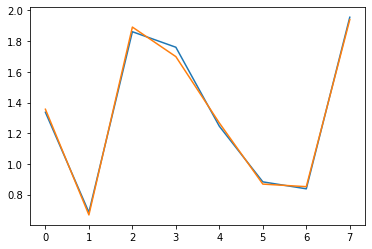

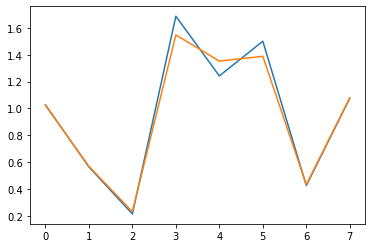

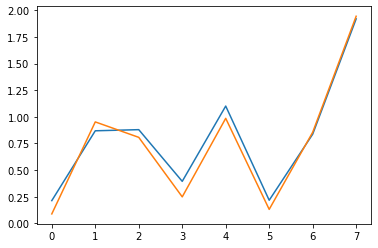

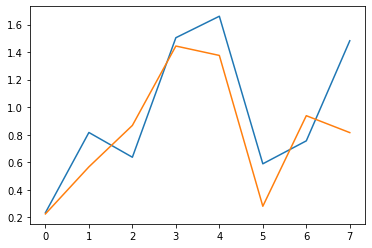

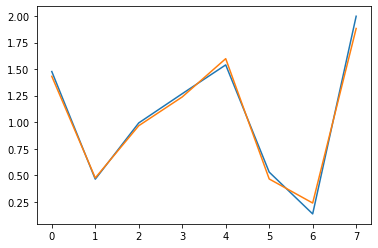

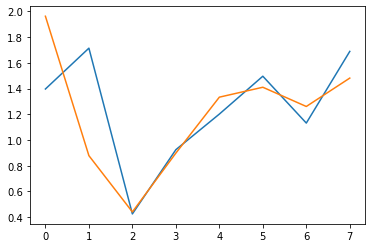

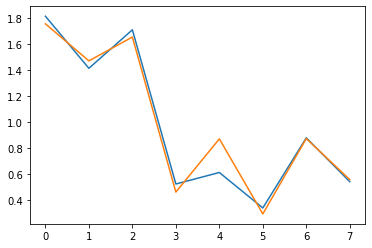

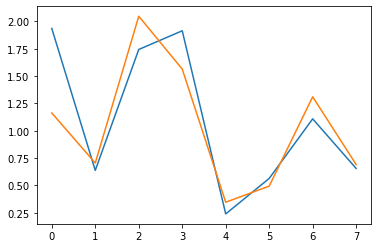

In [16]:
for i in range(10):
    plt.plot(h_torch[i,1,:].detach().numpy())
    plt.plot(-1*grad[i,:].detach().numpy())
    plt.show()

Visualization $\Delta \mathbf{f}$

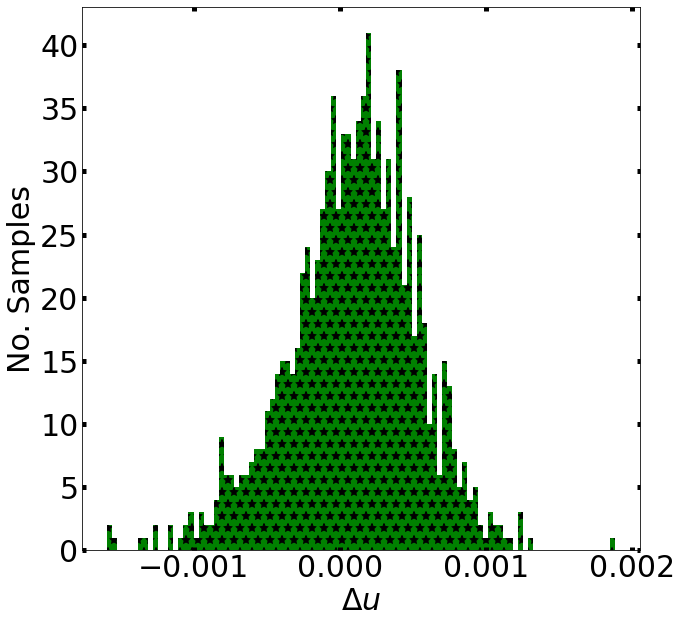

In [9]:
plt.figure(figsize=(10,10))
plt.hist(df.detach().numpy(),bins=100,color='green',hatch='*')
plt.xlabel(r'$\Delta u$',fontsize=30)
plt.ylabel(r'No. Samples',fontsize=30)
plt.tick_params(
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        direction="in",
        labelsize=30,
        width=5,
    )
plt.show()

#### Energy computation

In [21]:
z=z_torch[:,0,:].detach().unsqueeze(1)
x=z_torch[:,1,:].detach().unsqueeze(1)
z.requires_grad_(True)

input=torch.cat((z,x),dim=1)

energy=Energy_XXZX(model=model)

e_ml=energy(z=input,h=h_torch)
e_ml.backward(torch.ones_like(e_ml))


print(torch.mean(torch.abs(e_ml-e_torch)/torch.abs(e_torch)))

print(e_ml[0],e_torch[0])



tensor(0.0002, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(-17.6678, dtype=torch.float64, grad_fn=<SelectBackward0>) tensor(-17.6679, dtype=torch.float64)


#### Accuracy of the Gradient

In [25]:
# the gradient should be zero because we are in the ground state
with torch.no_grad():
    grad = z.grad.clone()
    z.grad.zero_()


In [30]:
print(grad[0,0])

tensor([ 0.8445,  0.3313,  2.4621,  0.8979,  1.3166,  0.0411,  0.1923, -0.2914],
       dtype=torch.float64)


Visualization, Part 1: $\mathbf{x}[\mathbf{z}]$

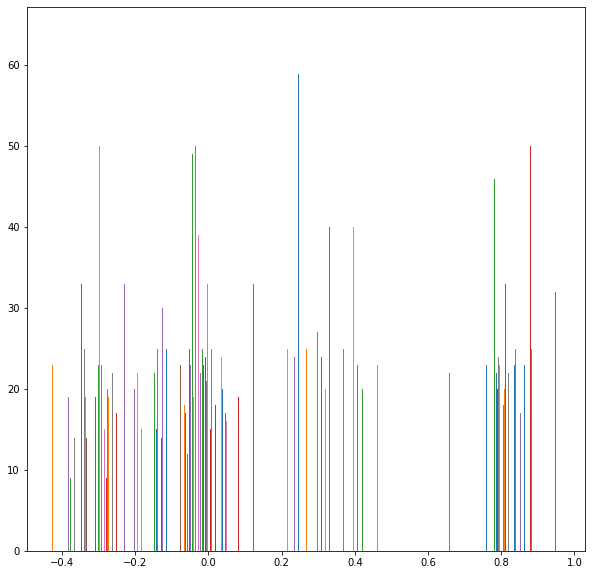

In [20]:
plt.figure(figsize=(10,10))
plt.hist(f_ml[:,0].detach().numpy(),bins=200)
plt.show()

### Test the DL-DFT neural network with the two magnetizations $\mathbf{z}$

Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.training.models_adiabatic import Energy_XXZX_1input

Data

In [2]:
data=np.load('data/kohm_sham_approach/disorder/reduction_1_input_channel_dataset_h_2.7_costant_omega_1.0_j_1_1nn_n_150000.npz')

ndata=1000

z=data['density']
f=data['density_F']
h=data['potential']
e=data['energy']

z_torch=torch.from_numpy(z[:ndata])
f_torch=torch.from_numpy(f[:ndata])
h_torch=torch.from_numpy(h[:ndata])
e_torch=torch.from_numpy(e[:ndata])
print(e_torch[0])

model=torch.load('model_rep/kohm_sham/disorder/model_zzxz_reduction_1_input_channel_f_h_2.7_constant_omega_1.0_j_1_1nn_150k_unet_l_train_8_[40, 40, 40, 40, 40, 40]_hc_5_ks_1_ps_6_nconv_0_nblock',map_location='cpu')
model.eval()

energy=Energy_XXZX_1input(model=model)


tensor(-14.7878, dtype=torch.float64)


See the samples

Magnetization $\mathbf{z}$

In [ ]:
for i in range(0,10):
    plt.plot(f[i,:])
    plt.plot(h[i,0,:])
    plt.show()

Test

Respect to z

In [3]:

f_ml=model(z_torch)
print('z shape=',z_torch.shape)
f_sum=f_ml.sum(-1)
f_sum=f_sum.view(-1)



df=torch.mean((f_ml-f_torch),dim=-1)
df_abs=torch.mean(torch.abs((f_ml-f_torch)),dim=-1)
print(df_abs.shape)
print(df_abs[:,1].mean())

z shape= torch.Size([1000, 8])
torch.Size([1000, 2])
tensor(6.7257e-05, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [4]:
z_torch.requires_grad_(True)
print(z_torch.shape)
print(h_torch.shape)
eng=energy.batch_estimation(z=z_torch,h=h_torch)
eng.backward(torch.ones_like(eng))

de=torch.mean(torch.abs((eng-e_torch)/e_torch))

print(de.item())

torch.Size([1000, 8])
torch.Size([1000, 2, 8])
1.9143068126972945e-05


Visualization of $\mathbf{f}$

In [ ]:
for i in range(10):
    plt.plot(f_ml.detach().numpy()[i,1,:])
    plt.plot(f_torch.detach().numpy()[i,1,:])
    plt.show()

Gradient of $f_{ml}$

In [5]:
with torch.no_grad():
    grad = z_torch.grad.clone()
    z_torch.grad.zero_()
print(grad.shape)
grad=grad

print(grad.shape)



torch.Size([1000, 8])
torch.Size([1000, 8])


The reconstruction of the field respect to $\mathbf{z}$

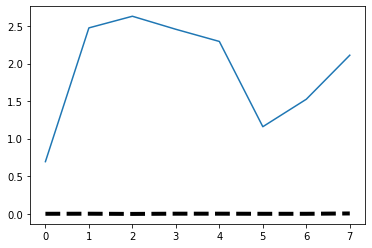

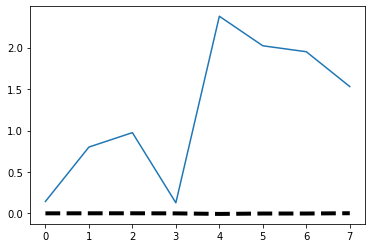

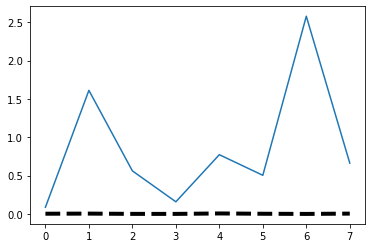

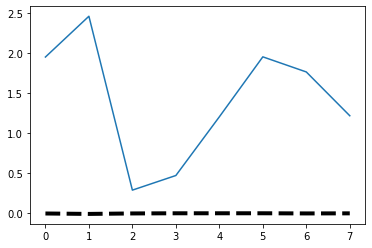

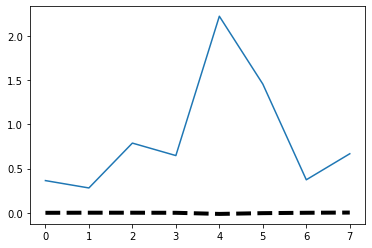

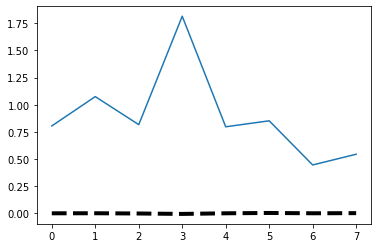

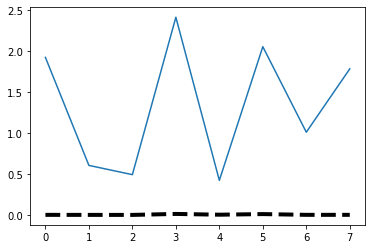

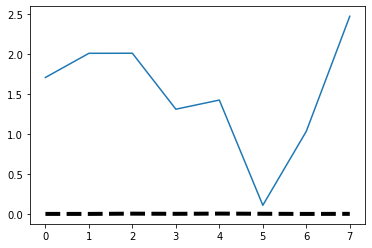

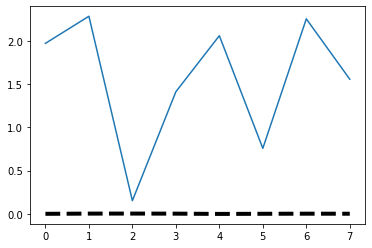

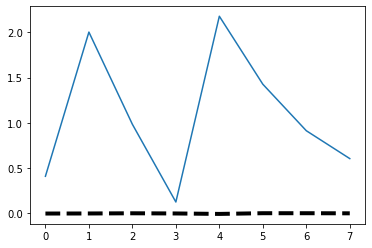

In [7]:
for i in range(10):
    plt.plot(h_torch[i,0,:].detach().numpy())
    plt.plot(-1*grad[i,:].detach().numpy(),color='black',linestyle='--',linewidth=4)
    plt.show()

Computing the Jacobian $\frac{\delta x_i}{\delta z_j}$

In [ ]:
z_torch.requires_grad_(True)

for i in range(z_torch.shape[-1]):
    f=energy.functional_value(z_torch)[:,1,i]
    f.backward(torch.ones_like(f),retain_graph=True)
    with torch.no_grad():
        grad_x = z_torch.grad.clone()
        z_torch.grad.zero_()
        
        if i==0:
            jacobian=grad_x.unsqueeze(-2)
        else:
            jacobian=torch.cat((jacobian,grad_x.unsqueeze(-2)),dim=-2)
        
print(jacobian.shape)

    
        
        
        






Compute the quantity $\frac{\delta F}{\delta x_i}= \frac{\delta z_j}{\delta x_i}\frac{\delta F}{\delta z_j}$

Regularization of the Jacobian

torch.Size([1000, 8, 8])
(1000,)


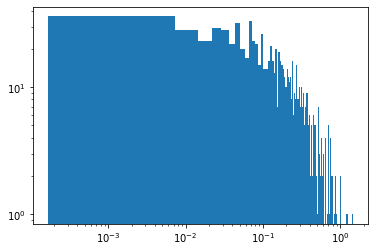

In [38]:
v,w=torch.linalg.eigh(jacobian)

v_restored=v+5*10**-3

identity=torch.eye(z_torch.shape[-1])
v_matrix=torch.einsum('bj,ij->bij',1/v_restored,identity)

print(v_matrix.shape)
inverse_jacobian=torch.einsum('bji,bik,bkr->bjr',w,v_matrix,w.conj())


v_min=torch.abs(v).detach().numpy()
v_min=np.min(v_min,axis=-1)
print(v_min.shape)
plt.hist(v_min,bins=200)
plt.loglog()
plt.show()



Inversion of the Corrected Jacobian

In [39]:
grad_x=torch.einsum('bij,bj->bi',inverse_jacobian,grad)

In [ ]:
for i in range(10):
    plt.plot(-1*grad_x[i,:].detach().numpy())
    plt.show()

Visualization $\Delta \mathbf{f}$

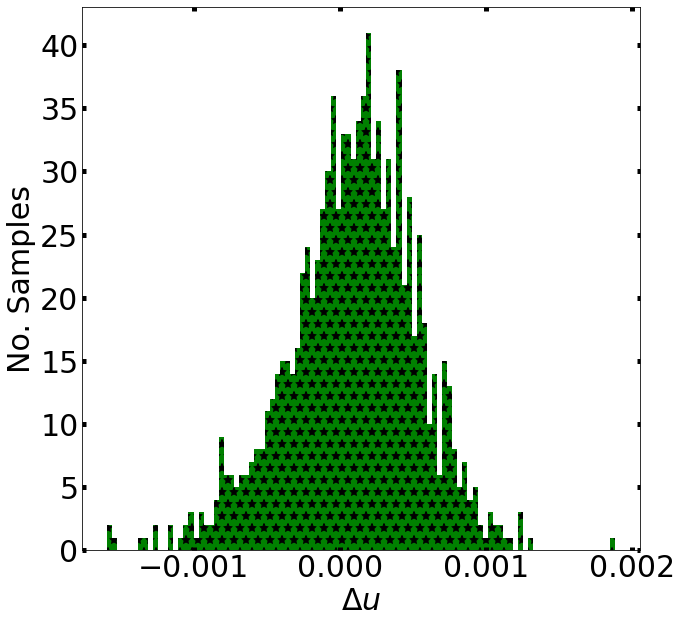

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(df.detach().numpy(),bins=100,color='green',hatch='*')
plt.xlabel(r'$\Delta u$',fontsize=30)
plt.ylabel(r'No. Samples',fontsize=30)
plt.tick_params(
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        direction="in",
        labelsize=30,
        width=5,
    )
plt.show()

#### Energy computation

In [ ]:
z=z_torch[:,0,:].detach().unsqueeze(1)
x=z_torch[:,1,:].detach().unsqueeze(1)
z.requires_grad_(True)

input=torch.cat((z,x),dim=1)

energy=Energy_XXZX(model=model)

e_ml=energy(z=input,h=h_torch)
e_ml.backward(torch.ones_like(e_ml))


print(torch.mean(torch.abs(e_ml-e_torch)/torch.abs(e_torch)))

print(e_ml[0],e_torch[0])



tensor(0.0002, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(-17.6678, dtype=torch.float64, grad_fn=<SelectBackward0>) tensor(-17.6679, dtype=torch.float64)


#### Accuracy of the Gradient

In [ ]:
# the gradient should be zero because we are in the ground state
with torch.no_grad():
    grad = z.grad.clone()
    z.grad.zero_()


In [ ]:
print(grad[0,0])

tensor([ 0.8445,  0.3313,  2.4621,  0.8979,  1.3166,  0.0411,  0.1923, -0.2914],
       dtype=torch.float64)


Visualization, Part 1: $\mathbf{x}[\mathbf{z}]$

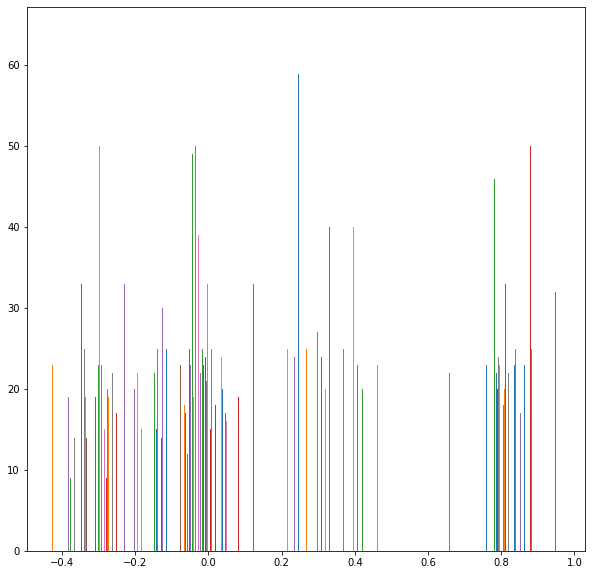

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(f_ml[:,0].detach().numpy(),bins=200)
plt.show()

#### Check the DL-DFT Model in the Qutip Dataset of disorder Configurations

Imports

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from src.training.models_adiabatic import Energy_XXZX

Data

In [ ]:
data=np.load('data/disorder/test_for_adiabatic_size_8_tf_10.0_dt_0.01_rate_1.0_h_2.7_n_dataset_10.npz')

ndata=1000

z=data['density']
h=data['potential']
time=data['time']

z_torch=torch.from_numpy(z[:ndata])
h_torch=torch.from_numpy(h[:ndata])
print(z_torch.shape)

model=torch.load('model_rep/kohm_sham/model_zzxz_reduction_150k_unet_l_train_8_[40, 40, 40, 40, 40, 40]_hc_5_ks_1_ps_6_nconv_0_nblock',map_location='cpu')
model.eval()

energy=Energy_XXZX(model=model)


torch.Size([10, 1000, 8])


Test of the energy functional over the evolution configurations $\mathbf{z}(t)$

In [ ]:
emls:List[np.ndarray]=[]

#sample
for i in range(z_torch.shape[0]):
    e_ml=energy(z_torch[i],h_torch[i])
    emls.append(e_ml.detach().numpy())

Visualization

In [ ]:
for e in emls:
    plt.plot(time,e)
    plt.xlabel(r'$t [1/J]$')
    plt.ylabel(r'$e_{ml}(t)$')
    plt.show()

Functional derivative of $\braket{\hat{Z}_i \hat{Z}_{i+1}}=f_i$ over the evolution configuration $\mathbf{z}(t)$

In [ ]:
grads:List[np.ndarray]=[]

z_torch.requires_grad_(False)

for i in range(z_torch.shape[0]):
    phi=z_torch[i]
    phi.requires_grad_(True)
    f=model(phi).mean(-1)[:,0]
    print(f.shape)
    f.backward(torch.ones_like(f))
    print(phi.requires_grad)
    with torch.no_grad():
            grad = phi.grad.clone()
            print(grad.shape)
            grads.append(grad.detach().numpy())
            phi.grad.zero_()
            



Visualization

In [ ]:
for i,grad in enumerate(grads):
    plt.title(f'title ={i}')
    print(grad.shape)
    plt.plot(time,grad)
    plt.show()

This study check the stability of the DL-DFT method tested on possible time evolution samples like $\mathbf{z}(t)$. This is the starting point to apply the Crank-Nicholson algorithm

### Test the functional derivative Neural network

Imports

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt


Data

In [ ]:
data=np.load('data/kohm_sham_approach/disorder/reduction_1_input_channel_dataset_h_2.7_costant_omega_1.0_j_1_1nn_n_150000.npz')

ndata=1000

z=data['density']
f=data['density_F']
h=data['potential']
e=data['energy']

z_torch=torch.from_numpy(z[:ndata])
f_torch=torch.from_numpy(f[:ndata])
h_torch=torch.from_numpy(h[:ndata])
e_torch=torch.from_numpy(e[:ndata])
print(e_torch[0])

model=torch.load('model_rep/kohm_sham/disorder/model_zzxz_reduction_1_input_channel_f_h_2.7_constant_omega_1.0_j_1_1nn_150k_unet_l_train_8_[40, 40, 40, 40, 40, 40]_hc_5_ks_1_ps_6_nconv_0_nblock',map_location='cpu')
model.eval()

energy=Energy_XXZX_1input(model=model)


tensor(-14.7878, dtype=torch.float64)


See the samples

Magnetization $\mathbf{z}$

In [ ]:
for i in range(0,10):
    plt.plot(f[i,:])
    plt.plot(h[i,0,:])
    plt.show()

Test

Respect to z

In [ ]:

f_ml=model(z_torch)
print('z shape=',z_torch.shape)
f_sum=f_ml.sum(-1)
f_sum=f_sum.view(-1)



df=torch.mean((f_ml-f_torch),dim=-1)
df_abs=torch.mean(torch.abs((f_ml-f_torch)),dim=-1)
print(df_abs.shape)
print(df_abs[:,1].mean())

z shape= torch.Size([1000, 8])
torch.Size([1000, 2])
tensor(6.7257e-05, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [ ]:
z_torch.requires_grad_(True)
print(z_torch.shape)
print(h_torch.shape)
eng=energy.batch_estimation(z=z_torch,h=h_torch)
eng.backward(torch.ones_like(eng))

de=torch.mean(torch.abs((eng-e_torch)/e_torch))

print(de.item())

torch.Size([1000, 8])
torch.Size([1000, 2, 8])


1.9143068126972945e-05


Visualization of $\mathbf{f}$

In [ ]:
for i in range(10):
    plt.plot(f_ml.detach().numpy()[i,1,:])
    plt.plot(f_torch.detach().numpy()[i,1,:])
    plt.show()

Gradient of $f_{ml}$

In [ ]:
with torch.no_grad():
    grad = z_torch.grad.clone()
    z_torch.grad.zero_()
print(grad.shape)
grad=grad

print(grad.shape)



torch.Size([1000, 8])
torch.Size([1000, 8])


The reconstruction of the field respect to $\mathbf{z}$

In [ ]:
for i in range(10):
    #plt.plot(h_torch[i,0,:].detach().numpy())
    plt.plot(-1*grad[i,:].detach().numpy(),color='black',linestyle='--',linewidth=4)
    plt.show()

Computing the Jacobian $\frac{\delta x_i}{\delta z_j}$

In [ ]:
z_torch.requires_grad_(True)

for i in range(z_torch.shape[-1]):
    f=energy.functional_value(z_torch)[:,1,i]
    f.backward(torch.ones_like(f),retain_graph=True)
    with torch.no_grad():
        grad_x = z_torch.grad.clone()
        z_torch.grad.zero_()
        
        if i==0:
            jacobian=grad_x.unsqueeze(-2)
        else:
            jacobian=torch.cat((jacobian,grad_x.unsqueeze(-2)),dim=-2)
        
print(jacobian.shape)

    
        
        
        






Compute the quantity $\frac{\delta F}{\delta x_i}= \frac{\delta z_j}{\delta x_i}\frac{\delta F}{\delta z_j}$

Regularization of the Jacobian

torch.Size([1000, 8, 8])
(1000,)


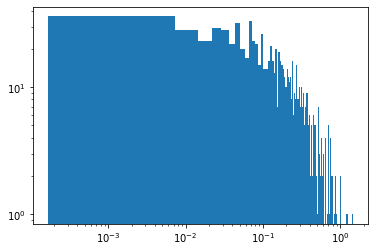

In [ ]:
v,w=torch.linalg.eigh(jacobian)

v_restored=v+5*10**-3

identity=torch.eye(z_torch.shape[-1])
v_matrix=torch.einsum('bj,ij->bij',1/v_restored,identity)

print(v_matrix.shape)
inverse_jacobian=torch.einsum('bji,bik,bkr->bjr',w,v_matrix,w.conj())


v_min=torch.abs(v).detach().numpy()
v_min=np.min(v_min,axis=-1)
print(v_min.shape)
plt.hist(v_min,bins=200)
plt.loglog()
plt.show()



Inversion of the Corrected Jacobian

In [ ]:
grad_x=torch.einsum('bij,bj->bi',inverse_jacobian,grad)

In [ ]:
for i in range(10):
    plt.plot(-1*grad_x[i,:].detach().numpy())
    plt.show()

Visualization $\Delta \mathbf{f}$

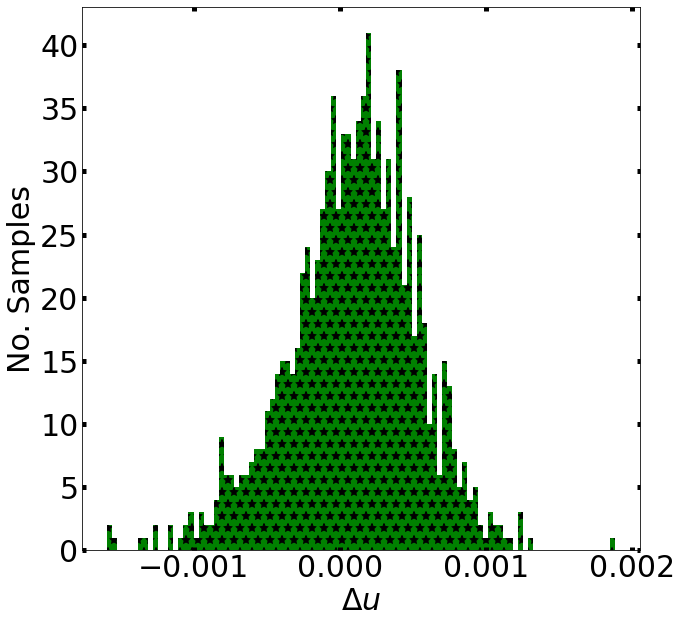

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(df.detach().numpy(),bins=100,color='green',hatch='*')
plt.xlabel(r'$\Delta u$',fontsize=30)
plt.ylabel(r'No. Samples',fontsize=30)
plt.tick_params(
        top=True,
        right=True,
        labeltop=False,
        labelright=False,
        direction="in",
        labelsize=30,
        width=5,
    )
plt.show()

#### Energy computation

In [ ]:
z=z_torch[:,0,:].detach().unsqueeze(1)
x=z_torch[:,1,:].detach().unsqueeze(1)
z.requires_grad_(True)

input=torch.cat((z,x),dim=1)

energy=Energy_XXZX(model=model)

e_ml=energy(z=input,h=h_torch)
e_ml.backward(torch.ones_like(e_ml))


print(torch.mean(torch.abs(e_ml-e_torch)/torch.abs(e_torch)))

print(e_ml[0],e_torch[0])



tensor(0.0002, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(-17.6678, dtype=torch.float64, grad_fn=<SelectBackward0>) tensor(-17.6679, dtype=torch.float64)


#### Accuracy of the Gradient

In [ ]:
# the gradient should be zero because we are in the ground state
with torch.no_grad():
    grad = z.grad.clone()
    z.grad.zero_()


In [ ]:
print(grad[0,0])

tensor([ 0.8445,  0.3313,  2.4621,  0.8979,  1.3166,  0.0411,  0.1923, -0.2914],
       dtype=torch.float64)


Visualization, Part 1: $\mathbf{x}[\mathbf{z}]$

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(f_ml[:,0].detach().numpy(),bins=200)
plt.show()

#### Check the DL-DFT Model in the Qutip Dataset of disorder Configurations

Imports

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from src.training.models_adiabatic import Energy_XXZX

Data

In [ ]:
data=np.load('data/disorder/test_for_adiabatic_size_8_tf_10.0_dt_0.01_rate_1.0_h_2.7_n_dataset_10.npz')

ndata=1000

z=data['density']
h=data['potential']
time=data['time']

z_torch=torch.from_numpy(z[:ndata])
h_torch=torch.from_numpy(h[:ndata])
print(z_torch.shape)

model=torch.load('model_rep/kohm_sham/model_zzxz_reduction_150k_unet_l_train_8_[40, 40, 40, 40, 40, 40]_hc_5_ks_1_ps_6_nconv_0_nblock',map_location='cpu')
model.eval()

energy=Energy_XXZX(model=model)


torch.Size([10, 1000, 8])


Test of the energy functional over the evolution configurations $\mathbf{z}(t)$

In [ ]:
emls:List[np.ndarray]=[]

#sample
for i in range(z_torch.shape[0]):
    e_ml=energy(z_torch[i],h_torch[i])
    emls.append(e_ml.detach().numpy())

Visualization

In [ ]:
for e in emls:
    plt.plot(time,e)
    plt.xlabel(r'$t [1/J]$')
    plt.ylabel(r'$e_{ml}(t)$')
    plt.show()

Functional derivative of $\braket{\hat{Z}_i \hat{Z}_{i+1}}=f_i$ over the evolution configuration $\mathbf{z}(t)$

In [ ]:
grads:List[np.ndarray]=[]

z_torch.requires_grad_(False)

for i in range(z_torch.shape[0]):
    phi=z_torch[i]
    phi.requires_grad_(True)
    f=model(phi).mean(-1)[:,0]
    print(f.shape)
    f.backward(torch.ones_like(f))
    print(phi.requires_grad)
    with torch.no_grad():
            grad = phi.grad.clone()
            print(grad.shape)
            grads.append(grad.detach().numpy())
            phi.grad.zero_()
            



Visualization

In [ ]:
for i,grad in enumerate(grads):
    plt.title(f'title ={i}')
    print(grad.shape)
    plt.plot(time,grad)
    plt.show()

This study check the stability of the DL-DFT method tested on possible time evolution samples like $\mathbf{z}(t)$. This is the starting point to apply the Crank-Nicholson algorithm